## Imports

In [1]:
import numpy as np
import madmom as mm
import librosa as lr
import librosa.display as display
import pretty_midi as pm
import matplotlib.pyplot as plt

## Constants

In [2]:
DATAPOINT = "../datasets/maps/CH/" + \
            "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
MIDI_DATAPOINT = "../datasets/maps/CH/" + \
        "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"

## Preprocess Datapoint

#### Generate spect:

In [3]:
log_filt = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    DATAPOINT,
    num_bands=48,
    num_channels=1, 
    sr=44100,
    unique_filters=True,
    norm_filters=True,
    frame_size=4096,
    fft_size=4096,
    fps=100, # 31.25 trash
    fmin=30,
    fmax=8000.0,
    fref=440.0,
    circular_shift=False,
    hop_size=441.0)

In [4]:
log_filt = lr.util.normalize(log_filt)

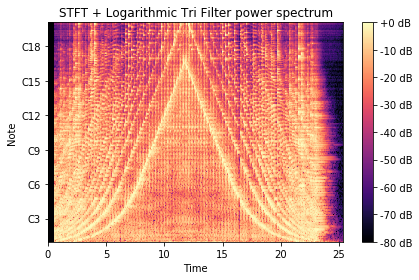

In [5]:
lr.display.specshow(
    lr.amplitude_to_db(log_filt, ref=np.max).T, 
    sr=44100,
    x_axis='time',
    y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT + Logarithmic Tri Filter power spectrum')
plt.tight_layout()

#### Generate ground truths:

In [6]:
times = lr.frames_to_time(
    np.arange(log_filt.shape[0]),
    sr=44100,
    hop_length=441.0)
midi = pm.PrettyMIDI(MIDI_DATAPOINT)

In [7]:
yFrom = midi.get_piano_roll(fs=44100, times=times)[21:108+1].T
yFrom[yFrom > 0] = 1

In [8]:
def generate_midi_onsets(midi):
    midi_onsets = midi
    
    # Modify notes to be all onsets within 50ms (0.05 seconds)
    for note in midi_onsets.instruments[0].notes:
        temp = note.start
        note.start = temp - 0.05
        note.end = temp
    
    return midi_onsets


def generate_midi_offsets(midi):
    midi_offsets = midi
    
    # Modify notes to be all offsets within 50ms (0.05 seconds)
    for note in midi_offsets.instruments[0].notes:
        temp = note.end
        note.start = note.end
        note.end = temp + 0.05
    
    return midi_onsets

# sample = midi.instruments[0].notes[0]
# print sample
# new_note = sample
# temp = new_note.start
# new_note.end = temp
# new_note.start = new_note.end - 0.1
# print new_note

In [9]:
midi_onsets = generate_midi_onsets(midi)
yOn = midi_onsets.get_piano_roll(fs=44100, times=times)[21:108+1].T
yOn[yOn > 0] = 1

In [10]:
midi_offsets = generate_midi_offsets(midi)
yOff = midi_offsets.get_piano_roll(fs=44100, times=times)[21:108+1].T
yOff[yOff > 0] = 1

## Visualize Datapoint with Ground Truths

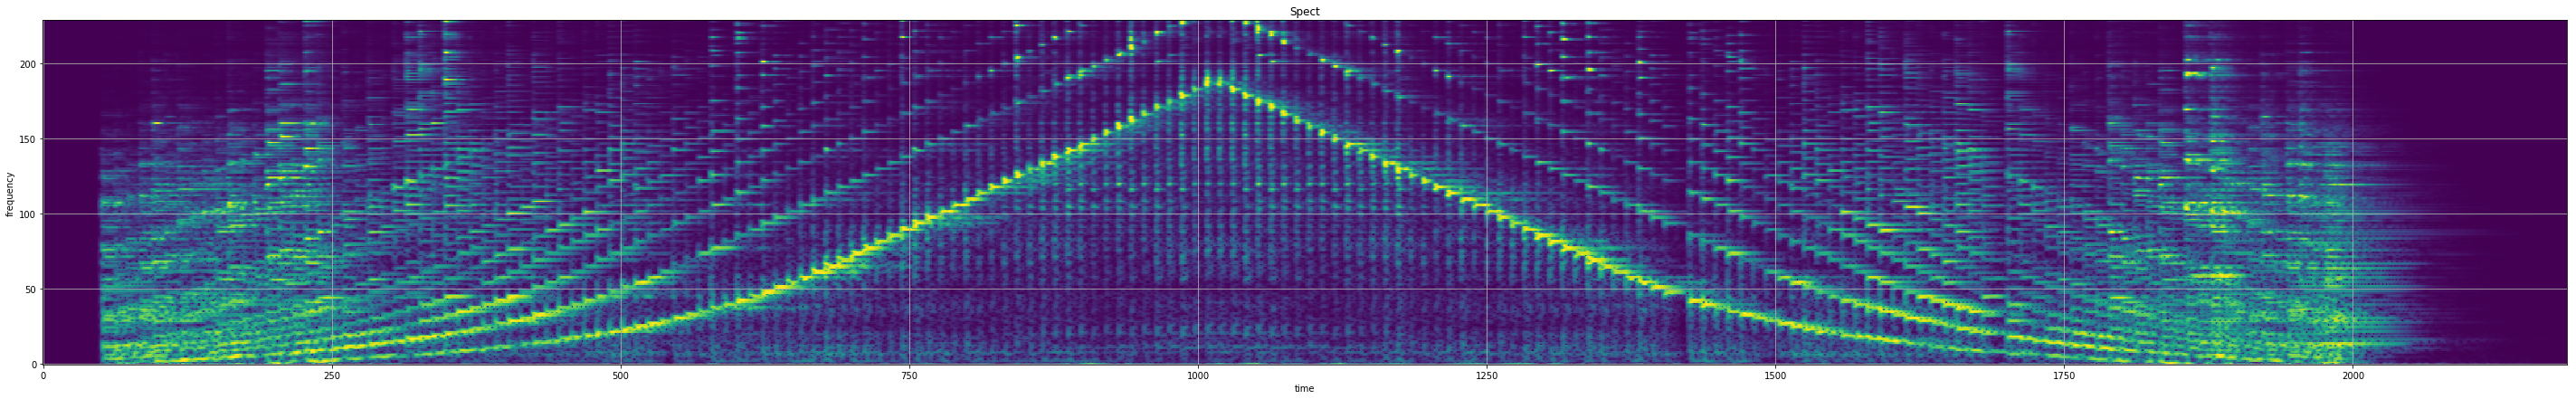

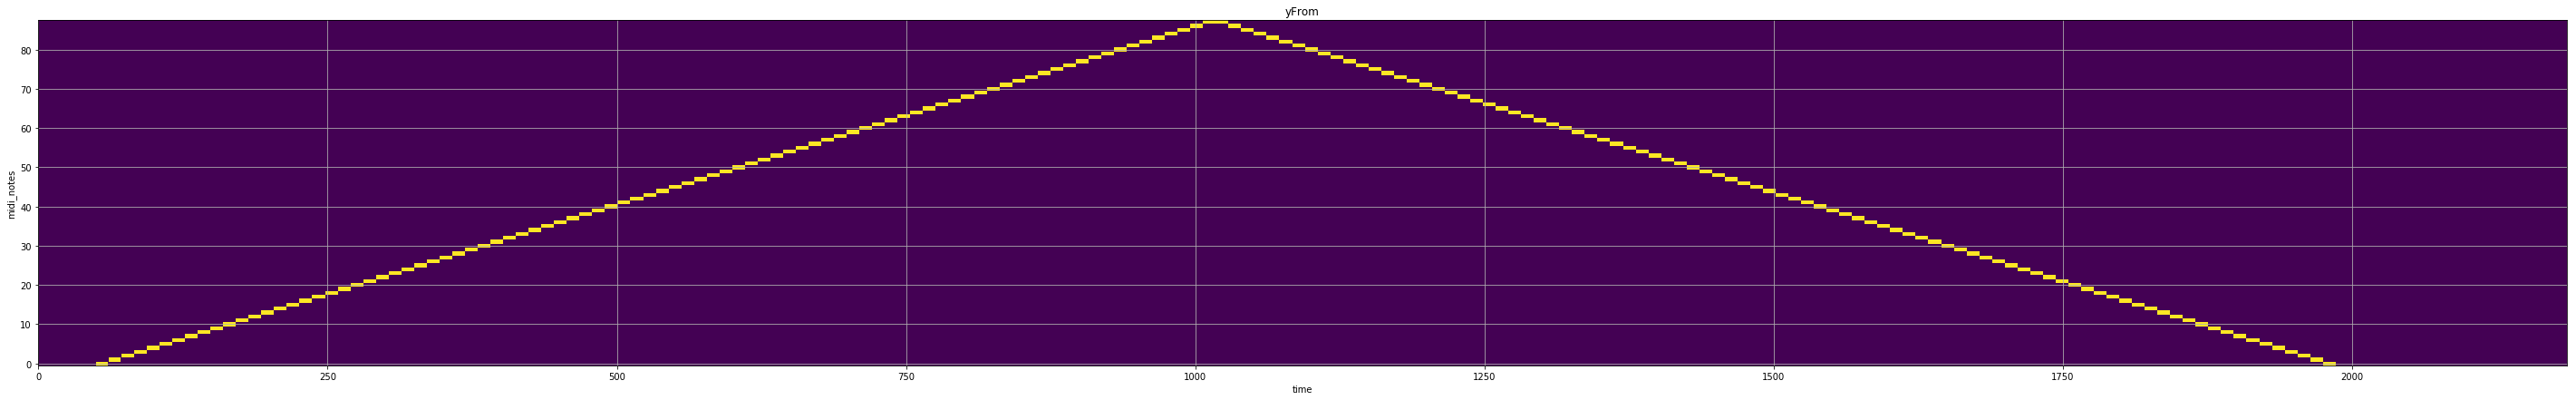

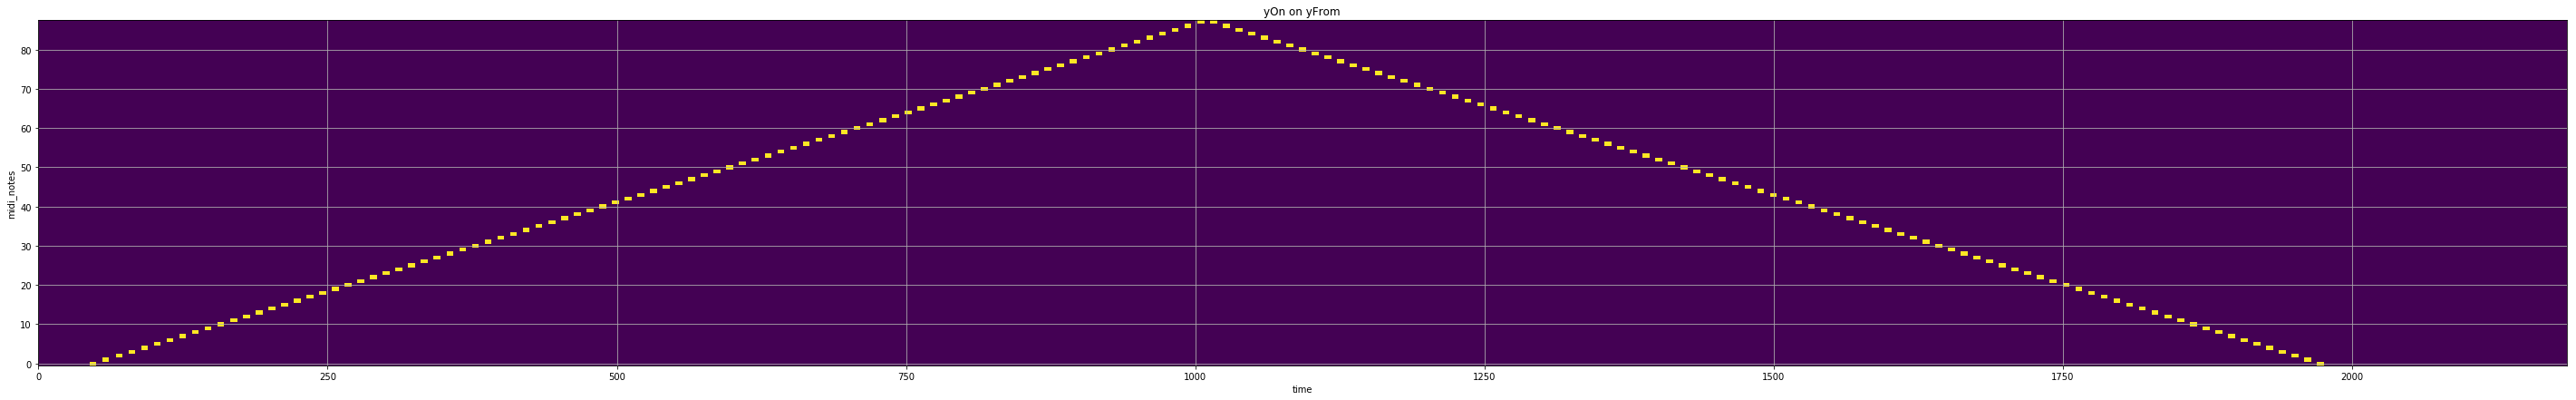

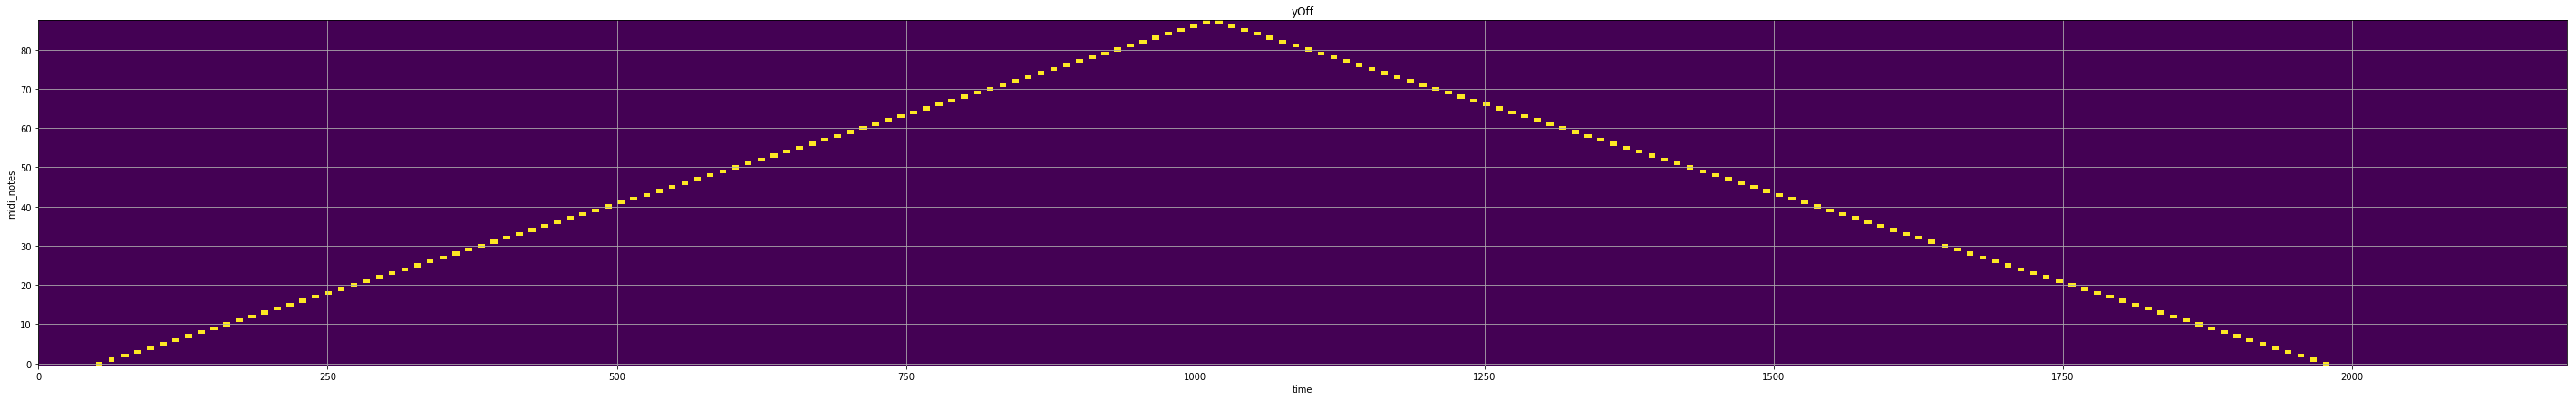

In [26]:
length = 50

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(log_filt.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
plt.title("Spect")
plt.show()

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(yFrom.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.title("yFrom")
plt.show()

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(yOn.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.title("yOn on yFrom")
plt.show()

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(yOff.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.title("yOff")
plt.show()